In [1]:
import torch
import nibabel as nib
import numpy as np
import os

In [2]:
device = torch.device("cpu")
model_path = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\models\final_model_script.pt"
flair_model = torch.jit.load(model_path, map_location=device)
flair_model.eval()
print("FLAIR-only model loaded and set to evaluation mode on CPU.")

FLAIR-only model loaded and set to evaluation mode on CPU.


In [3]:
# 2. Provide the Path to the FLAIR Volume (User Upload)
flair_volume_path = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\UPenn_GBM\images\UPENN-GBM-00254_11\UPENN-GBM-00254_11_FLAIR.nii.gz"  
if not os.path.exists(flair_volume_path):
    raise FileNotFoundError(f"FLAIR file not found: {flair_volume_path}")

In [4]:
# 3. Load the FLAIR Volume
flair_nii = nib.load(flair_volume_path)
flair_data = flair_nii.get_fdata()  # shape: [H, W, D]
print("FLAIR volume shape:", flair_data.shape)

FLAIR volume shape: (240, 240, 155)


In [5]:
# 4. Run Inference on Each Slice to Produce a 3D Segmentation
num_slices = flair_data.shape[2]
pred_volume = np.zeros(flair_data.shape, dtype=np.uint8)

for i in range(num_slices):
    slice_data = flair_data[:, :, i]
    
    # Normalize slice to [0,1]
    min_val = np.min(slice_data)
    max_val = np.max(slice_data)
    norm_slice = (slice_data - min_val) / (max_val - min_val + 1e-8)
    
    # Prepare input tensor: [1,1,H,W]
    input_tensor = torch.tensor(norm_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = flair_model(input_tensor)
    # Convert logits to probabilities and threshold
    pred_probs = torch.sigmoid(output).cpu().numpy()[0, 0]
    pred_mask = (pred_probs > 0.5).astype(np.uint8)
    
    pred_volume[:, :, i] = pred_mask

print("Segmentation prediction complete.")

Segmentation prediction complete.


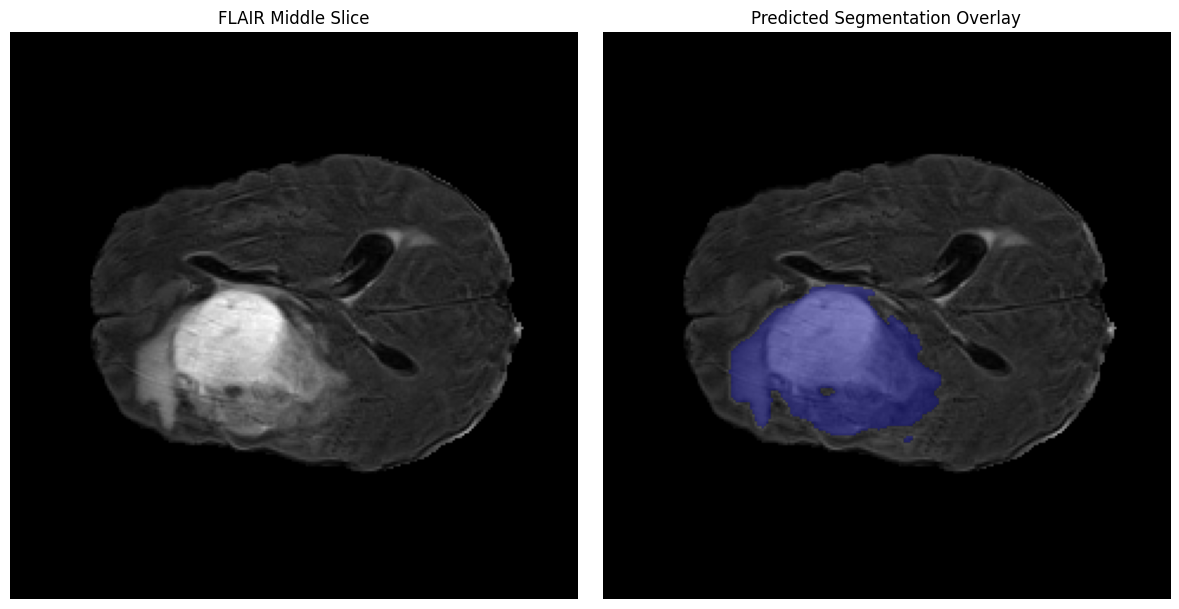

Visualization complete.


In [6]:
# 5. Visualize the Middle Slice with an Overlay
import matplotlib.pyplot as plt
middle_slice = num_slices // 2
original_slice = flair_data[:, :, middle_slice]
predicted_mask = pred_volume[:, :, middle_slice]

plt.figure(figsize=(12,6))

# Left: Original FLAIR Middle Slice
plt.subplot(1, 2, 1)
plt.imshow(original_slice, cmap='gray')
plt.title("FLAIR Middle Slice")
plt.axis('off')

# Right: Overlay
plt.subplot(1, 2, 2)
plt.imshow(original_slice, cmap='gray')
# Overlay the predicted mask in a color (e.g., 'jet') with some transparency
plt.imshow(np.ma.masked_where(predicted_mask == 0, predicted_mask),
           cmap='jet', alpha=0.5)
plt.title("Predicted Segmentation Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Visualization complete.")